In [1]:
import pandas as pd
import numpy as np
import h2o

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA  # Principal component
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML as ml

from functions.datacleaning import MoscowHousing as mh
from functions.distance import get_distance_coordinates, norm_features, PCA_plot

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

# Prepare NaN Values

In [2]:
# Get data
data = mh(
          coordinates=None,
          data_train="../prepared_data/train_prepared.csv",
          data_test="../prepared_data/test_prepared.csv",
          # test_prepared.csv is already complete
          need_correction=False,
          # Base float values are already normalized with 0 as mean
          normalize = False,
          # Passing floats (not really necessary)
          features_float = ["area_total", 
                            "distance", 
                            "area_kitchen", 
                            "area_living", 
                            "ceiling",
                            "distance_metro"]
          )

In [3]:
XTrain, YTrain = data.get_data_train()
XTest = data.get_data_test()

In [4]:
XTrain.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,0,18450,NaN,11300000.0,-0.011096,153116.531165,-0.541037,0.263027,1,3,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,10.252880,286.45
1,1,20065,1.0,7100000.0,-0.553098,169047.619048,-0.388730,-0.596888,5,1,...,2.0,17,0.0,1.0,1.0,1.0,1.0,0.0,36.091930,16183.78
2,2,2137,0.0,13600000.0,0.009357,181333.333333,-0.388730,0.517816,3,3,...,3.0,12,0.0,1.0,0.0,1.0,1.0,0.0,12.374064,956.44
3,3,4155,1.0,10100000.0,-0.263348,171186.440678,NaN,NaN,2,2,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,15.232969,1405.21
4,3,8798,1.0,10100000.0,-0.263348,171186.440678,-0.084116,-0.262477,2,2,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,15.232969,1405.21


In [5]:
YTrain.head()

0    11300000.0
1     7100000.0
2    13600000.0
3    10100000.0
4    10100000.0
Name: price, dtype: float64

In [6]:
XTest.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,4,26052,NaN,5.675295,NaN,NaN,3,6,NaN,NaN,...,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,22.208129,4981.58
1,5,29404,1.0,-0.896821,-1.581108,-0.588336,1,1,NaN,-0.077026,...,3.0,12,0.0,1.0,0.0,NaN,1.0,NaN,16.744106,499.31
2,6,24089,2.0,0.494253,-0.417982,0.678815,3,4,1.0,-0.068230,...,3.0,22,0.0,1.0,1.0,1.0,1.0,0.0,11.886858,1123.52
3,11,24033,0.0,0.087932,0.163582,0.165921,11,3,NaN,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,15.455810,955.56
4,11,32976,1.0,0.096804,-0.316208,0.368062,5,3,1.0,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,15.455810,955.56


# Prepare Data

In [7]:
features_float_train = ["price", "price_per_square_meter", 
                        "distance", "distance_metro"]

features_float_test = ["distance", "distance_metro"]

X_Train = XTrain.copy()
Y_Train = YTrain.copy()
X_Test = XTest.copy()



# Replace ceiling NaN with 0 (= mean because values are z-scores)
X_Train["ceiling"] = X_Train["ceiling"].fillna(0.0)
X_Test["ceiling"] = X_Test["ceiling"].fillna(0.0)

# Normalize not yet normalized float values
X_Train[features_float_train] = norm_features(X_Train[features_float_train])
X_Test[features_float_test] = norm_features(X_Test[features_float_test])

X_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   building_id             23285 non-null  int64  
 1   id                      23285 non-null  int64  
 2   seller                  14455 non-null  float64
 3   price                   23285 non-null  float64
 4   area_total              23285 non-null  float64
 5   price_per_square_meter  23285 non-null  float64
 6   area_kitchen            18564 non-null  float64
 7   area_living             19403 non-null  float64
 8   floor                   23285 non-null  int64  
 9   rooms                   23285 non-null  int64  
 10  layout                  5643 non-null   float64
 11  ceiling                 23285 non-null  float64
 12  bathrooms_shared        19413 non-null  float64
 13  bathrooms_private       19413 non-null  float64
 14  windows_court           15213 non-null

# One Hot Encoding

In [8]:
hot_list = ["seller", "layout", "condition", "new", 
            "material", "garbage_chute", "heating"]

def hot_encode(x, hot):
    #x = X.copy()
    for h in hot:
        df = pd.get_dummies(x[h], prefix=h, dummy_na=True)
        x = pd.concat([x, df], axis=1)
    # Currenty the dropping of original column is done in 
    # the section "Remove Features" (otherwise activate)
    #x = x.drop(hot, axis=1) 
    return x

# Hotlist all variables in hot_list
X1 = hot_encode(X_Train[hot_list], hot_list)
X2 = hot_encode(X_Test[hot_list], hot_list)

X_Train = pd.concat([X_Train, X1], axis=1)

X_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 78 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   building_id             23285 non-null  int64  
 1   id                      23285 non-null  int64  
 2   seller                  14455 non-null  float64
 3   price                   23285 non-null  float64
 4   area_total              23285 non-null  float64
 5   price_per_square_meter  23285 non-null  float64
 6   area_kitchen            18564 non-null  float64
 7   area_living             19403 non-null  float64
 8   floor                   23285 non-null  int64  
 9   rooms                   23285 non-null  int64  
 10  layout                  5643 non-null   float64
 11  ceiling                 23285 non-null  float64
 12  bathrooms_shared        19413 non-null  float64
 13  bathrooms_private       19413 non-null  float64
 14  windows_court           15213 non-null

# Remove Features

In [9]:
# Features to remove in both training and test data
features_remove_train = ["area_kitchen", "area_living", "layout",
                         "seller", "condition",
                         "windows_court", "windows_street",
                         "bathrooms_shared", "bathrooms_private",
                         "balconies", "loggias", "countpattern_street",
                         "constructed",
                         "material", 
                         "elevator_without", 
                         "elevator_passenger", "elevator_service", "parking", 
                         "garbage_chute", "heating", "latitude", "longitude", 
                         "street", "address", "phones", "new"]

features_remove_test = ["area_kitchen", "area_living", "layout",
                        "seller", "condition",
                        "windows_court", "windows_street",
                        "bathrooms_shared", "bathrooms_private",
                        "balconies", "loggias",
                        "constructed",
                        "material", 
                        "elevator_without", 
                        "elevator_passenger", "elevator_service", "parking", 
                        "garbage_chute", "heating", "latitude", "longitude", 
                        "street", "address", "phones", "new"]


# First prep - remove unwanted features
X_Train = X_Train.drop(features_remove_train, axis=1)
X_Test = X_Test.drop(features_remove_test, axis=1)
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   building_id             23285 non-null  int64  
 1   id                      23285 non-null  int64  
 2   price                   23285 non-null  float64
 3   area_total              23285 non-null  float64
 4   price_per_square_meter  23285 non-null  float64
 5   floor                   23285 non-null  int64  
 6   rooms                   23285 non-null  int64  
 7   ceiling                 23285 non-null  float64
 8   district                23285 non-null  int64  
 9   stories                 23285 non-null  int64  
 10  distance                23285 non-null  float64
 11  distance_metro          23285 non-null  float64
 12  seller_0.0              23285 non-null  uint8  
 13  seller_1.0              23285 non-null  uint8  
 14  seller_2.0              23285 non-null

In [12]:
X_Train.head()

,building_id,id,price,area_total,price_per_square_meter,floor,rooms,ceiling,district,stories,...,material_6.0,material_nan,garbage_chute_0.0,garbage_chute_1.0,garbage_chute_nan,heating_0.0,heating_1.0,heating_2.0,heating_3.0,heating_nan
0,0,18450,-0.232813,-0.011096,-0.556842,1,3,0.000000,3,5,...,0,1,0,0,1,0,0,0,0,1
1,1,20065,-0.312594,-0.553098,-0.463212,5,1,0.000000,9,17,...,0,0,0,1,0,1,0,0,0,0
2,2,2137,-0.189123,0.009357,-0.391007,3,3,-0.058168,2,12,...,0,0,0,1,0,1,0,0,0,0
3,3,4155,-0.255607,-0.263348,-0.450642,2,2,0.000000,3,7,...,0,0,0,0,1,1,0,0,0,0
4,3,8798,-0.255607,-0.263348,-0.450642,2,2,-0.061871,3,7,...,0,0,0,0,1,1,0,0,0,0


# PCA analysis

In [34]:
X = X_Train.copy()
y = Y_Train.copy()

features1 = ["area_total",
             "rooms",
             "floor",
             "distance",
             "distance_metro"]

features2 = ["area_total",
             "rooms",
             "floor",
             "distance",
             "distance_metro",
             "ceiling", "district", "stories", 
             "seller_0.0", "seller_1.0","seller_2.0","seller_3.0", "seller_nan",
             "layout_1.0", "layout_2.0", "layout_nan", 
             "condition_0.0", "condition_1.0", "condition_2.0", 
             "condition_3.0", "condition_nan", 
             "new_0.0", "new_1.0", "new_nan", 
             "material_0.0", "material_1.0", "material_2.0", 
             "material_3.0", "material_4.0", "material_5.0",
             "material_6.0", "material_nan", 
             "garbage_chute_0.0", "garbage_chute_1.0", "garbage_chute_nan", 
             "heating_0.0", "heating_1.0", "heating_2.0", 
             "heating_3.0", "heating_nan"]


In [35]:
print(X.shape)
print(y.shape)
print(X[features1].shape)

(23285, 45)
(23285,)
(23285, 5)


In [36]:
X[features1].head()

,area_total,rooms,floor,distance,distance_metro
0,-0.011096,3,1,-0.315749,-0.385108
1,-0.553098,1,5,2.903551,4.059285
2,0.009357,3,3,-0.051469,-0.197800
3,-0.263348,2,2,0.304723,-0.072338
4,-0.263348,2,2,0.304723,-0.072338


In [52]:
pca_model = PCA(n_components=10)

In [53]:
pca_train = pca_model.fit_transform(X[features2])

In [54]:
def PCA_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.4)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')


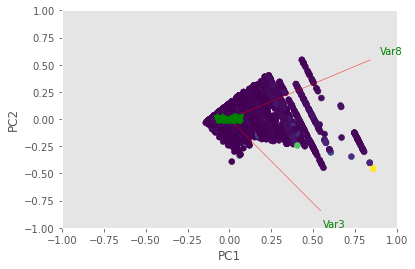

In [55]:
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
PCA_plot(pca_train[:,0:2],np.transpose(pca_model.components_[0:2, :]))
plt.show()

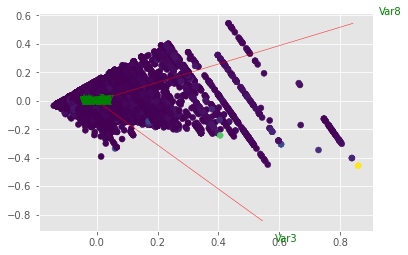

In [56]:
# Test if plot function works from functions
c = np.transpose(pca_model.components_[0:2, :])
PCA_plot(pca_train, c)

In [57]:
pca_model.explained_variance_ratio_

array([0.77868283, 0.13352391, 0.04990839, 0.00883019, 0.00608055,
       0.00524032, 0.00244244, 0.0018789 , 0.00174485, 0.00147063])

In [58]:
# Components have shape n_components, n_features
# First row = PC1 ----> most important variable is number 3 = "floor" 
# Second row = PC2 ---> equally most important 1,2,4
# Third row = PC3 ----> most important 5
print(abs(pca_model.components_))

[[1.48198751e-02 7.06255056e-03 5.42851408e-01 8.83366277e-03
  9.74780390e-03 2.54525961e-04 7.83412166e-03 8.39285206e-01
  1.40875932e-03 5.31456767e-03 2.00194132e-03 4.89279385e-03
  3.83247445e-03 2.08408581e-03 3.05636490e-04 2.79755107e-03
  1.97480601e-03 5.96657959e-03 2.24926192e-03 1.63958240e-03
  4.60145310e-03 5.80169023e-03 6.28168411e-03 4.79993881e-04
  4.15548499e-03 8.94181514e-06 9.97986944e-03 5.07287902e-03
  1.20682098e-03 3.72151266e-04 6.18013584e-06 9.82862264e-05
  1.48772102e-03 3.36270986e-03 4.85043089e-03 3.04937845e-04
  6.12231960e-04 2.70423551e-04 3.32330855e-05 3.63747819e-06]
 [6.72162304e-03 1.13417698e-03 8.39553948e-01 4.79743601e-03
  5.84026371e-03 5.75455004e-04 1.30235412e-02 5.42834402e-01
  9.78403505e-04 2.81971771e-03 1.79038338e-03 3.35704683e-03
  2.23145777e-03 2.19184771e-03 2.78687674e-04 2.85061984e-03
  2.41087300e-03 4.14130242e-03 5.71110260e-04 5.02835647e-04
  2.80437533e-03 4.27695128e-03 4.65401445e-03 3.77063177e-04
  3.973

In [59]:
print(pca_model.components_.shape[0])

10


In [60]:
# PRINT most important features given PCA on complete X_test[feature1]
n_pcs= pca_model.components_.shape[0]

most_important = [np.abs(pca_model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [features2[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())
df.head()

,0,1
0,PC0,stories
1,PC1,floor
2,PC2,district
3,PC3,rooms
4,PC4,distance_metro


In [61]:
most_important_names = [features2[most_important[i]] for i in range(n_pcs)]
print(most_important_names)

['stories', 'floor', 'district', 'rooms', 'distance_metro', 'distance_metro', 'ceiling', 'rooms', 'heating_nan', 'material_2.0']


In [62]:
# Template for replacing nan by computing other variables
#df["parking"] = df.groupby("district").transform(lambda x: x.fillna(x.median()))["parking"]

In [ ]:
#df.column_name.loc[df.column_name > max_value]  = max_value

In [ ]:
district_counts = {0:{},1:{},2:{},3:{},4:{},5:{},6:{},7:{},8:{},9:{},10:{},11:{},12:{}}
districts = XTrain["district"]
for d in districts:
    pass